# Final Analysis and Thermodynamics of Ising Model

I'm gonna do the actual data analysis on MC simulation for square lattice of $(L,L)$ dimension , for L that goes from $10$ to $70$ in steps of $5$, each simulation consists in $2*10^{6}$ calls of the $\verb|Metropolis()|$ function that does an update of the lattice ($L*L$ local updates). 
<br>
Measures are taken every $25$ MC steps

In [279]:
import numpy as np
import concurrent.futures
from tqdm.notebook import tqdm
import os
import matplotlib as mpt
import matplotlib.pyplot as plt
from matplotlib import style
import pylab
#speed things up
import numba
from numba import njit
from numba import jit
from numba import prange
#from numba_progress import ProgressBar
#from scipy.ndimage import convolve, generate_binary_structure
from timeit import default_timer as timer
from time import sleep
#style designed by me for plottin (version 2)
plt.style.use(['science','notebook','grid'])
plt.rcParams['mathtext.fontset'] = 'stix'

fig = (9,6)
params = {'figure.figsize': fig,
        'legend.fontsize': 2.5*fig[1],
         'axes.labelsize': 2.8*fig[1],
         'axes.titlesize':4*fig[1],
         'xtick.labelsize':2*fig[1],
         'ytick.labelsize':2*fig[1],
         'font.family' : 'Stixgeneral'
          }
pylab.rcParams.update(params)


In [2]:
def getColor(c, N, idx):
    cmap=mpt.colormaps.get_cmap(c)
    norm = mpt.colors.Normalize(vmin=0.0, vmax=N - 1)
    return cmap(norm(idx))

In [3]:
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)

In [4]:
files = np.arange(10,75,5)
for file in tqdm(files):
    filename = f"simulation_{file}.txt"
    bs, es, ms = np.loadtxt(filename, unpack=True)
    if (file==10):
        energy_mat = np.zeros((len(bs),len(files)+1))
        magnes_mat = np.zeros((len(bs),len(files)+1)) 

    energy_mat[:,int(file/5-2)] = es
    magnes_mat[:,int(file/5-2)] = ms

  0%|          | 0/13 [00:00<?, ?it/s]

In [5]:
2000000/25 * len(beta_exp),len(bs)

(10080000.0, 10080000)

In [6]:
@jit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat):
    magns_L=np.zeros((len(beta_exp),len(files)))
    var_magns_L=np.zeros((len(beta_exp),len(files)))
    for i in range(0,len(files)):
        as_matrix = np.column_stack((bs,magnes_mat[:,i]))
        m=[]
        v=[]
        for b in (beta_exp):
            indices = as_matrix[:,0]
            mgns = np.sum(np.abs(as_matrix[(indices == b),1]))      # here one can 
            var=np.var(np.abs(as_matrix[(indices == b),1])[3000:])  # select the initial steps 
            mgns = mgns/(len(as_matrix[(indices == b),1]))          # which have to be neglected
            m.append(mgns)                                          #i.e. the point in the Markov-chain where to start averag, var ecc..
            v.append(var)
        magns_L[:,i]=m
        var_magns_L[:,i]=v
    return magns_L, var_magns_L

In [7]:
%time magns_L, var_magns_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat)

CPU times: user 48.6 s, sys: 3.77 s, total: 52.4 s
Wall time: 52.6 s


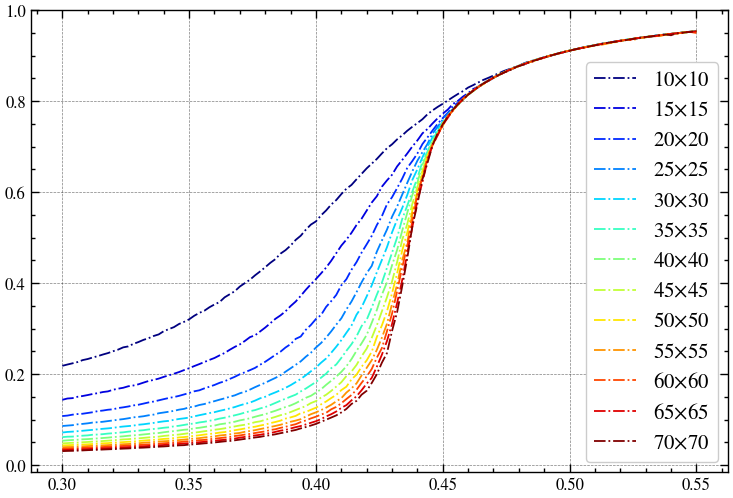

In [8]:
files = np.arange(10,75,5)
for file in files:
    plt.plot(beta_exp, magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.3',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

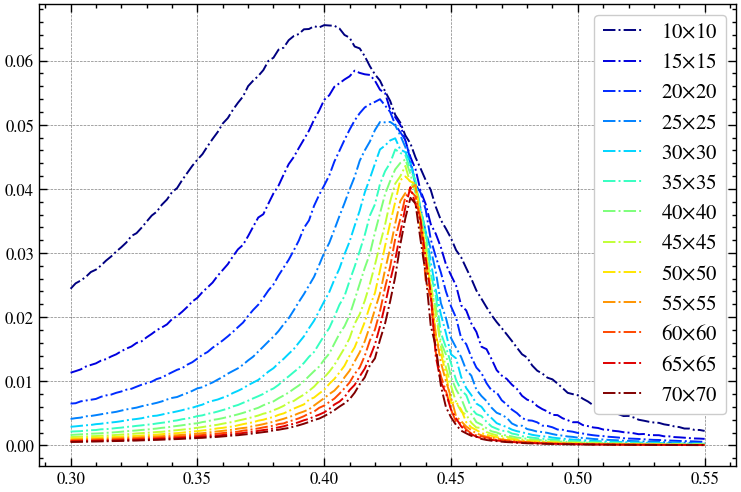

In [9]:
files = np.arange(10,75,5)
for file in files:
    i=int()
    plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.4',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))

plt.legend()    
plt.show()

In [ ]:
file=55
plt.plot(beta_exp, var_magns_L[:,int(file/5 - 2)],'+',markersize='5', linewidth='0.7',label=rf'{file}$ \times ${file}')

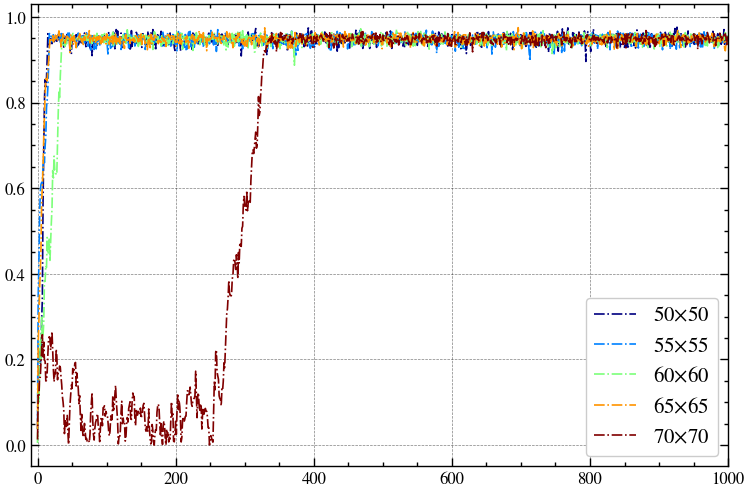

In [12]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.54,int(file/5 - 2)]),'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))
plt.xlim(-10,1000)
plt.legend()
plt.show()



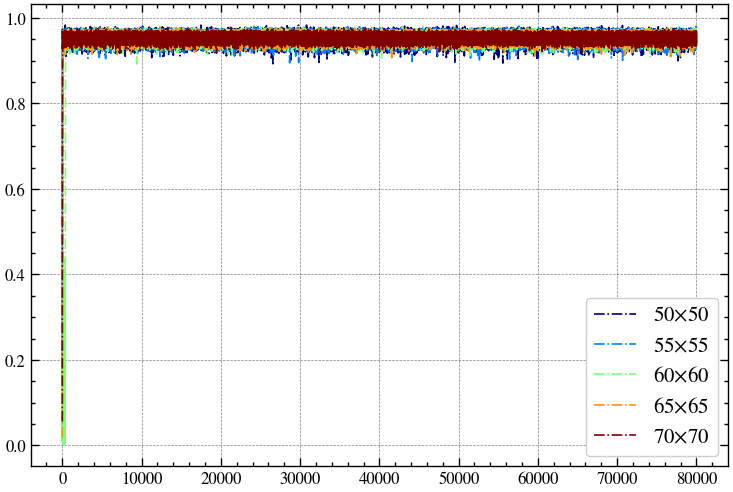

In [18]:
#storie mc per grossi reticoli e grossi beta
as_matrix = np.column_stack((bs,magnes_mat[:,0]))
ind = as_matrix[:,0]
files=np.arange(50,75,5)
for file in files: plt.plot(np.abs(magnes_mat[ind==0.55,int(file/5 - 2)]),'-.',markersize='9', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(((file-(files[0]-10)))/5 - 2)))
#plt.xlim(-50,600)
plt.legend()
plt.show()


In [39]:
#NOw let's collect all the data both magnetization and energy and then calculate the susceptibility
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)
files = np.arange(10,75,5)
@njit
def data_asmatrix(files, beta_exp, energy_mat, magnes_mat, N):
    magns_L = np.zeros((len(beta_exp),len(files)))
    enes_L = np.zeros((len(beta_exp),len(files)))
    heatc_L = np.zeros((len(beta_exp),len(files)))
    chi_L = np.zeros((len(beta_exp),len(files)))
    #var_magns_L=np.zeros((len(beta_exp),len(files)))
    for file in files:
        i = int(file/5-2)
        as_matrix_m = np.column_stack((bs,magnes_mat[:,i]))
        as_matrix_e = np.column_stack((bs,energy_mat[:,i]))
        m,vm = [],[]
        e, ve = [],[]
        for b in (beta_exp):
            indices = as_matrix_m[:,0]
            
            Nm = len(as_matrix_m[(indices == b),1][N:])
            Ne = len(as_matrix_e[(indices == b),1][N:])
            mgns = np.sum(np.abs(as_matrix_m[(indices == b),1][N:]))/Nm      
            enes = np.sum(as_matrix_e[(indices == b),1][N:])/Ne 
            heat_c = (np.sum((as_matrix_e[(indices == b),1][N:])**2)/Ne - (np.sum(as_matrix_e[(indices == b),1][N:])/Ne)**2)*file**2
            chi = (np.sum((as_matrix_m[(indices == b),1][N:])**2)/Nm - (np.sum(np.abs(as_matrix_m[(indices==b),1][N:]))/Nm)**2)*file**2
            ve.append(heat_c)
            vm.append(chi)
            m.append(mgns)                                           
            e.append(enes)
                 
        magns_L[:,i] = m
        enes_L[:,i] = e
        heatc_L[:,i] = ve
        chi_L[:,i] = vm
        
                 
    return magns_L, enes_L, heatc_L, chi_L

In [36]:
%time magns_L, enes_L, heatc_L, chi_L = data_asmatrix(files, beta_exp, energy_mat, magnes_mat, 0)

CPU times: user 2min 12s, sys: 12.2 s, total: 2min 24s
Wall time: 2min 24s


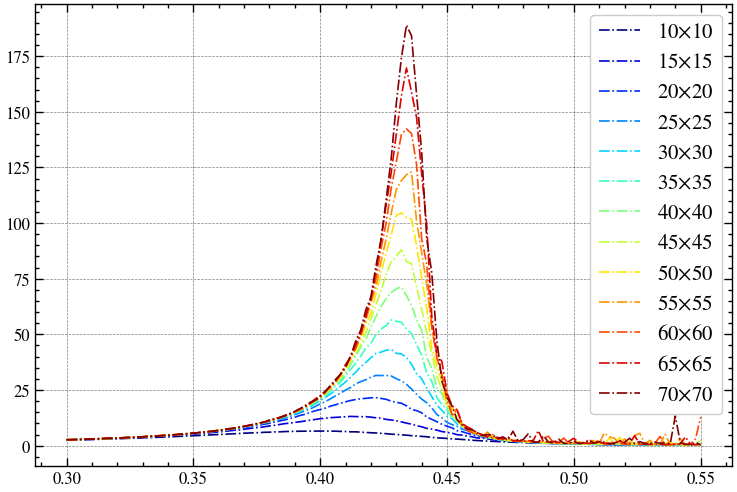

In [37]:
for file in files: 
    plt.plot(beta_exp, chi_L[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()
plt.show()

In [40]:
%time magns_Lf, enes_Lf, heatc_Lf, chi_Lf = data_asmatrix(files, beta_exp, energy_mat, magnes_mat, 10000)

CPU times: user 2min 8s, sys: 12.1 s, total: 2min 20s
Wall time: 2min 20s


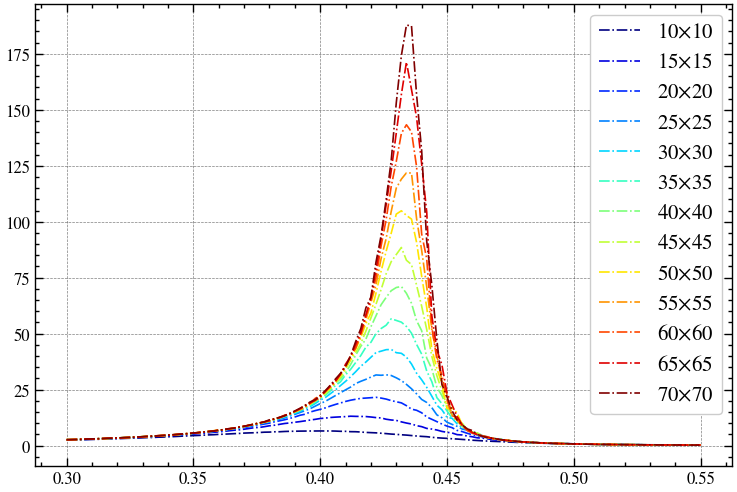

In [41]:
#tolto 10000 punti iniziali
for file in files: 
    plt.plot(beta_exp, chi_Lf[:,int(file/5 - 2)],'-.',markersize='6', linewidth='1.2',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()
plt.show()

In [134]:
len(magns_L[:,0])

126

In [181]:
def binned_bootstrap(data, bin_size, num_samples):
    # Calculate the number of bins.
    num_bins = int(np.ceil(len(data) / bin_size))

    # Create an array to store the bootstrap samples.
    bootstrap_samples = np.zeros((num_samples, len(data)))

    # Generate the bootstrap samples.
    for i in range(num_samples):
        # Sample with replacement from the bins.
        bin_indices = np.random.randint(num_bins, size=num_bins)
        bootstrap_bins = [data[bin_size*bi:bin_size*(bi+1)] for bi in bin_indices]
        # store the sample.
        bootstrap_samples[i] = np.concatenate(bootstrap_bins)

    return bootstrap_samples

In [147]:
n=80000
n.bit_length()-1, 2**16,80000-65536

(16, 65536, 14464)

In [ ]:
energy_mat[:,L] magnes_mat[:,L]

In [182]:
@njit #ricorda il valore assoluto magn quando chiami 
def bootstrap(boot):
    aver = np.zeros(boot.shape[0])
    d_aver = np.zeros(boot.shape[0])
    dd_aver = np.zeros(boot.shape[0])
    for i in range(0,boot.shape[0]):
        aver[i] = np.sum(boot[i])/boot.shape[1]   #average per campiionamento
        d_aver[i] = np.sum(boot[i]**2)/boot.shape[1] - (np.sum(boot[i])/boot.shape[1])**2
    
    average = np.sum(aver)/boot.shape[0]
    d_average = np.sum(d_aver)/boot.shape[0]    
    dx1 = 0
    dx = 0
    for i in range(0,boot.shape[0]):
        dx1 += (d_aver[i] - d_average)**2
        dx += (aver[i] - average)**2
    dx = np.sqrt(dx/(boot.shape[0]-1))
    dx1 = np.sqrt(dx/(boot.shape[0]-1))
    
    return dx,dx1        

    
    

In [135]:
beta_exp = np.round(np.arange(0.3,0.55,0.002), decimals=3)
files = np.arange(10,75,5)

In [246]:
files = np.arange(10,75,5)
magns_L = np.zeros((len(beta_exp),len(files)))
enes_L = np.zeros((len(beta_exp),len(files)))
heatc_L = np.zeros((len(beta_exp),len(files)))
chi_L = np.zeros((len(beta_exp),len(files)))
dmagns_L = np.zeros((len(beta_exp),len(files)))
denes_L = np.zeros((len(beta_exp),len(files)))
dheatc_L = np.zeros((len(beta_exp),len(files)))
dchi_L = np.zeros((len(beta_exp),len(files)))
N=5000

for file in tqdm(files):
    i = int(file/5-2)
    m, cchi, dm, dchi  = [],[],[],[]
    e, hc, de, dhc = [],[],[],[]
    for b in beta_exp:
        
        Nm = len(magnes_mat[(bs == b),i][N:])
        Ne = len(energy_mat[(bs == b),i][N:])
        mgns = np.sum(np.abs(magnes_mat[(bs == b),i][N:]))/Nm      
        enes = np.sum(energy_mat[(bs == b),i][N:])/Ne 
        heat_c = (np.sum((energy_mat[(bs == b),i][N:])**2)/Ne - (np.sum(energy_mat[(bs == b),i][N:])/Ne)**2)*file**2
        chi = (np.sum((magnes_mat[(bs == b),i][N:])**2)/Nm - (np.sum(np.abs(magnes_mat[(bs==b),i][N:]))/Nm)**2)*file**2
        
        
        boot_m = binned_bootstrap(np.abs(magnes_mat[bs==b,i][N:]), 2500, 2000)
        boot_e =binned_bootstrap(energy_mat[bs==b,i][N:], 2500, 2000)
        d_e, d_e1 = bootstrap(boot_e)
        d_m, d_m1 = bootstrap(boot_m)
        hc.append(heat_c)
        cchi.append(chi)
        m.append(mgns)                                           
        e.append(enes)
        dm.append(d_m)
        dchi.append(d_m1*file**2)
        de.append(d_e)
        dhc.append(d_e1*file**2)
    magns_L[:,i] = m
    enes_L[:,i] = e
    heatc_L[:,i] = hc
    chi_L[:,i] = cchi
    dmagns_L[:,i] = dm
    denes_L[:,i] = de
    dheatc_L[:,i] = dhc
    dchi_L[:,i] = dchi
        


  0%|          | 0/13 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


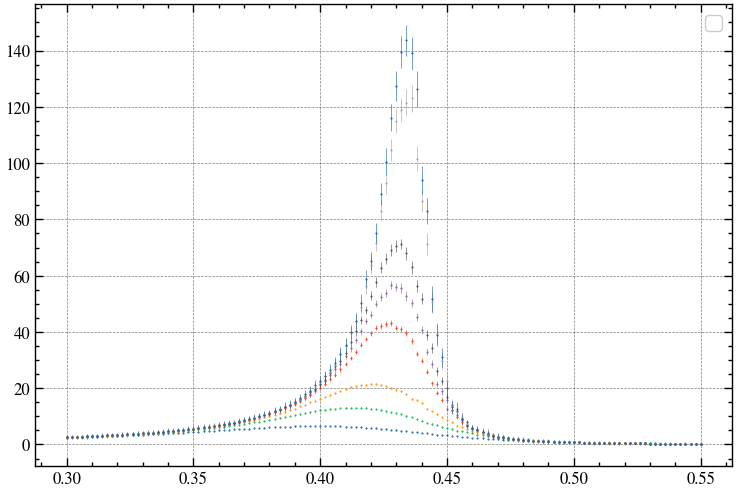

In [249]:
#plt.plot(beta_exp,dchi_L[:,0],label='1')
#plt.plot(beta_exp,dchi_L[:,1],label='2')
plt.errorbar(beta_exp, chi_L[:,0], dchi_L[:,0],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,1], dchi_L[:,1],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,2], dchi_L[:,2],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,4], dchi_L[:,4],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,5], dchi_L[:,5],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,6], dchi_L[:,6],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,9], dchi_L[:,9],fmt='.', elinewidth=.4,markersize=1)
plt.errorbar(beta_exp, chi_L[:,10], dchi_L[:,10],fmt='.', elinewidth=.4,markersize=1)
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


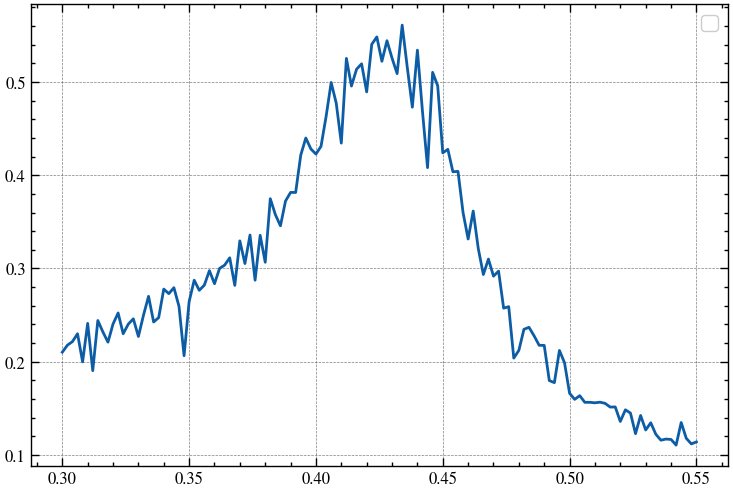

In [244]:
plt.plot(beta_exp,dchi_L[:,2])
plt.legend()

In [295]:
def write_file(bet, x, dx, name, firstrow):
    filepath =f'{name}.txt'
    with open(filepath, "w") as file:
        file.write('#' + '\t\t'.join(firstrow.split())+'\n')
        if (len(x)==len(dx)==len(bet) and len(firstrow.split())==3):
            for bi, xi, dxi in zip(bet, x, dx):
                file.write(f'{bi}\t\t{xi}\t\t{dxi}\n')     
        else: print('Errore!!! Problem in the shape of the args')

In [379]:
def threading(bet, x, dx, name, firstrow, files):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        for i,file in enumerate(files):
            fullname =f'{name}_{file}'
            executor.submit(write_file, bet, x[:,i], dx[:,i], fullname, firstrow)
        

In [381]:
direct='raw_data_from_sim'
os.mkdir(direct)
names = os.getcwd() + '/' + direct + '/' + 'simulation'
%time threading(bs, energy_mat, magnes_mat, names, 'betas energy magn', files)

CPU times: user 1min 51s, sys: 4.53 s, total: 1min 56s
Wall time: 2min 3s


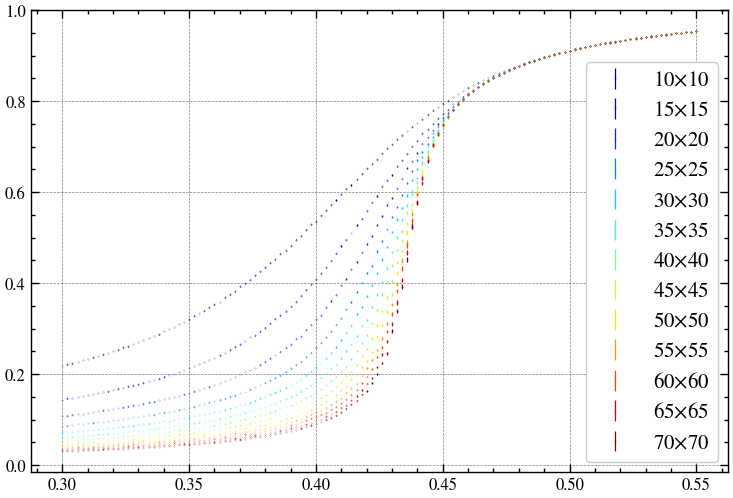

In [330]:
names = os.getcwd() + '/' + 'magn' + '/' + 'magn_'
for file in files:
    filename = f'{names}{file}.txt'
    betas, m, dm = np.loadtxt(filename, unpack=True)
    plt.errorbar(betas, m, dm,fmt='.', elinewidth=.9,markersize=.3,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()

plt.show()

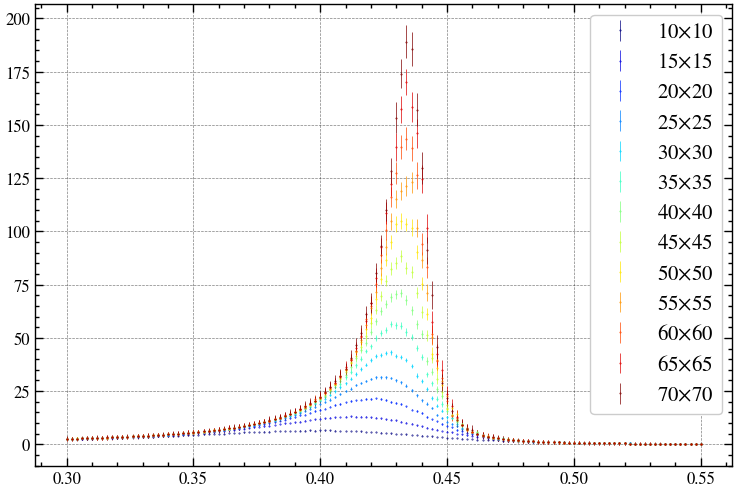

In [371]:
names = os.getcwd() + '/' + 'susceptibility' + '/' + 'chi_'
for file in files:
    filename = f'{names}{file}.txt'
    betas, m, dm = np.loadtxt(filename, unpack=True)
    plt.errorbar(betas, m, dm,fmt='.', elinewidth=.5,markersize=.8,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
plt.legend()

plt.show()

In [377]:
t=10
betas[t],dm[t], m[t], m[0], (dm[t]/m[t])*100

(0.32,
 1.1046296796438528,
 3.425988159186546,
 2.6357990083052036,
 32.24265900283007)

In [380]:
len(bs)

10080000

In [ ]:
#dati 

In [ ]:
energy_mat[:,int(file/5-2)] 
magnes_mat[:,int(file/5-2)] 

In [411]:
def blocking(data, bin_size):
    nb = int(len(data)/bin_size) #num of blocks
    #lets build the blocks with list comprehension
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    averages = np.array([b.mean() for b in blocks]) #average for each block
    return averages.std(ddof=1)/np.sqrt(nb) if nb > 1 else 0

In [412]:
def bootstrap_binned(data, bin_size, f, R):
    nb = int(len(data)/bin_size) #num of blocks
    re_samples = np.full(R,0.) #each row will contain the fake resampling std
    blocks = [data[i*bin_size : (i+1)*bin_size] for i in range(nb)]
    #let's pick randomly the block until all the sample is full
    tmp = np.full((nb,bin_size), 0.)
    for j in range(R):
        for k, b in enumerate(np.random.randint(0, nb, size=nb)):
            tmp[k] = blocks[b]
        re_samples[j] = f(tmp.flatten())
    return re_samples

In [413]:
def var_abs(data):
    return abs(data).std(ddof=1)**2

In [414]:
files = np.arange(10,75,5)
magns_L = np.zeros((len(beta_exp),len(files)))
enes_L = np.zeros((len(beta_exp),len(files)))
heatc_L = np.zeros((len(beta_exp),len(files)))
chi_L = np.zeros((len(beta_exp),len(files)))
dmagns_L = np.zeros((len(beta_exp),len(files)))
denes_L = np.zeros((len(beta_exp),len(files)))
dheatc_L = np.zeros((len(beta_exp),len(files)))
dchi_L = np.zeros((len(beta_exp),len(files)))
N=5000
#controlla problema degli abs
for i,file in enumerate(tqdm(files)):
    m, cchi, dm, dchi  = [],[],[],[]
    e, hc, de, dhc = [],[],[],[]
    for b in beta_exp:
        mgns = np.abs(magnes_mat[(bs == b),i][N:]).mean()      
        enes = energy_mat[(bs == b),i][N:].mean()
        heat_c = np.abs(energy_mat[(bs==b),i][N:]).var(ddof=1) * (file**2)
        chi = np.abs(magnes_mat[(bs==b),i][N:]).var(ddof=1) * (file**2)
        
        d_m = blocking(np.abs(magnes_mat[bs==b,i][N:]), 1000)
        d_e = blocking(energy_mat[bs==b,i][N:], 1000)
        d_chi = bootstrap_binned(magnes_mat[bs==b,i][N:], 1000, var_abs, 800).std(ddof=1)
        d_heatc = bootstrap_binned(energy_mat[bs==b,i][N:], 1000, var_abs, 800).std(ddof=1)
        # boot_m = binned_bootstrap(np.abs(magnes_mat[bs==b,i][N:]), 2500, 2000)
        # boot_e =binned_bootstrap(energy_mat[bs==b,i][N:], 2500, 2000)
        # d_e, d_e1 = bootstrap(boot_e)
        # d_m, d_m1 = bootstrap(boot_m)
        hc.append(heat_c)
        cchi.append(chi)
        m.append(mgns)                                           
        e.append(enes)
        dm.append(d_m)
        dchi.append(d_chi*file**2)
        de.append(d_e)
        dhc.append(d_heatc*file**2)
    magns_L[:,i] = m
    enes_L[:,i] = e
    heatc_L[:,i] = hc
    chi_L[:,i] = cchi
    dmagns_L[:,i] = dm
    denes_L[:,i] = de
    dheatc_L[:,i] = dhc
    dchi_L[:,i] = dchi

0it [00:00, ?it/s]

In [425]:
chi_L[8,12],dchi_L[8,12]

(3.2812551099285368, 0.020748404225962597)

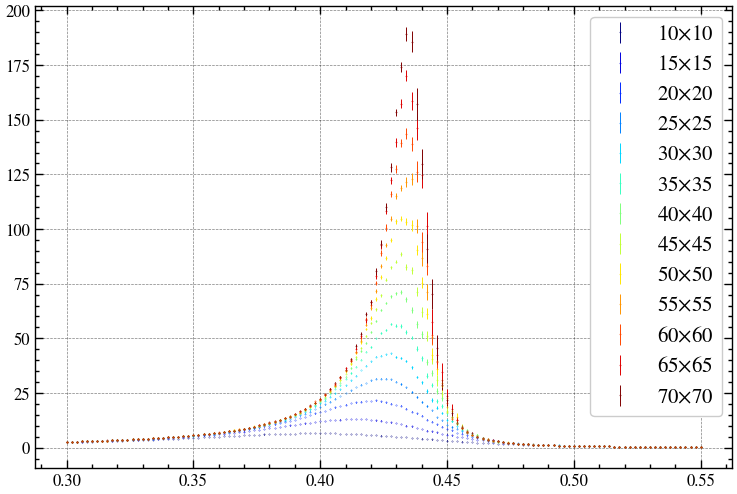

In [554]:
for i, file in enumerate(files):
    plt.errorbar(beta_exp, chi_L[:,i], dchi_L[:,i],fmt='.', elinewidth=.7,linewidth=.5,markersize=.5,label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),i))
plt.legend()

In [ ]:
#best blocksize
magnes_mat[bs == 0.40, 6]
for k in range()




In [508]:
chose_block = np.arange(100,1100,100)
a= np.insert(chose_block, 0, (1,10,30,50))
a= np.append(a,(1500,3000,5000,7500,12500))
a

array([    1,    10,    30,    50,   100,   200,   300,   400,   500,
         600,   700,   800,   900,  1000,  1500,  3000,  5000,  7500,
       12500])

  0%|          | 0/6 [00:00<?, ?it/s]

(-10.0, 5000.0)

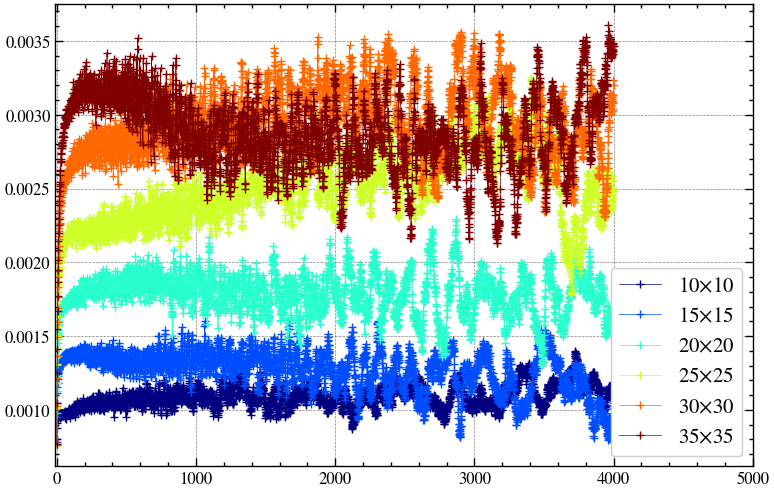

In [563]:
aa=np.arange(1,4000,1)
files = np.arange(10,40,5)
for i,file in enumerate(tqdm(files)):
    sigma_m_try =[]
    for k in aa:
        dm_try = blocking(np.abs(magnes_mat[bs == 0.436, i][10000:]), k)
        sigma_m_try.append(dm_try)
    plt.plot(aa , sigma_m_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
    
plt.legend(loc='lower right')
plt.xlim(-10,5000)

  0%|          | 0/13 [00:00<?, ?it/s]

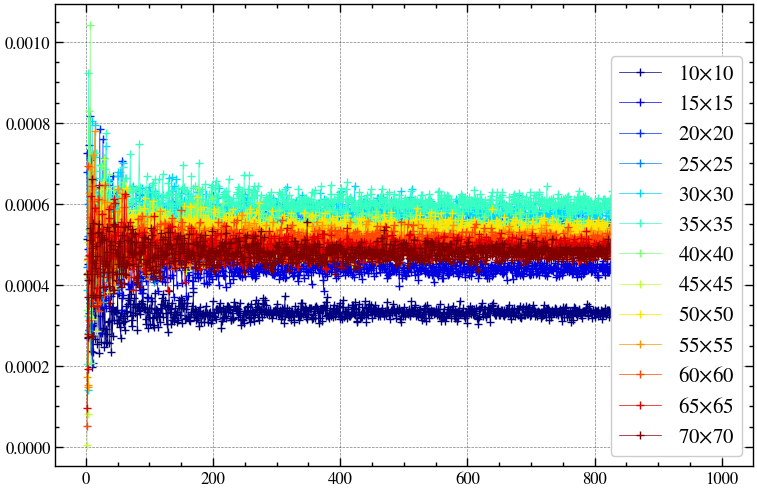

In [564]:
#best block/number of resamples beta=0.432
aa=np.arange(1,1000,1)
files = np.arange(10,75,5)
for i,file in enumerate(tqdm(files)):
    sigma_chi_try =[]
    for k in aa:
        dchi_try = bootstrap_binned(np.abs(magnes_mat[bs == 0.432, i][10000:]), 1000, var_abs, k).std(ddof=1)
        sigma_chi_try.append(dchi_try)
    plt.plot(aa , sigma_chi_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
    
plt.legend(loc='lower right')


  0%|          | 0/13 [00:00<?, ?it/s]

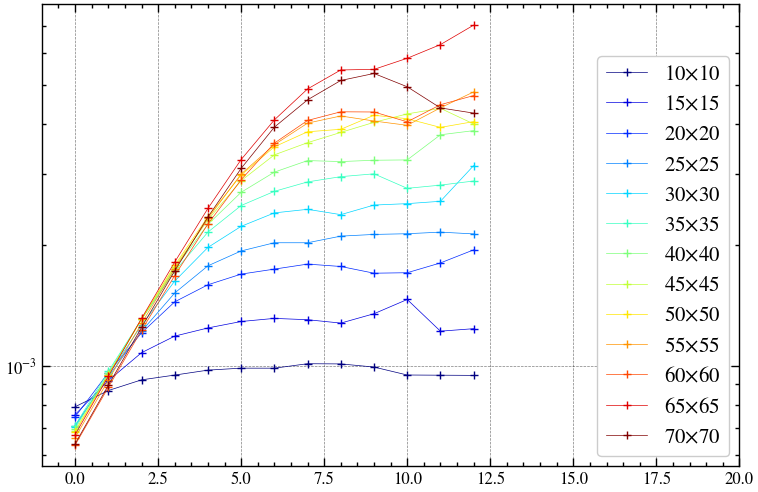

In [609]:
aa=np.arange(1,4000,1)
files = np.arange(10,75,5)
for i,file in enumerate(tqdm(files)):
    sigma_m_try =[]
    for k in range(0,13):
        dm_try = blocking(np.abs(magnes_mat[bs == 0.44, i][14464:]), 2**k)
        sigma_m_try.append(dm_try)
    plt.plot(list(range(0,13)) , sigma_m_try,'-+',markersize='6', linewidth='.5',label=rf'{file}$ \times ${file}',color=getColor('jet', len(files),int(file/5 - 2)))
    
plt.legend(loc='lower right')
plt.xlim(-1,20)
plt.yscale('log')


In [568]:
n=80000
n.bit_length()-1

16

In [569]:
80000-2**16

14464

In [570]:
list(range(1,17))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [594]:
2**10

1024